In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# Standard imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec

In [17]:
# Import OpenSense modules as submodules
import sys
import os

sys.path.append(os.path.abspath("./pycomlink/"))
sys.path.append(os.path.abspath("./poligrain/src/"))
sys.path.append(os.path.abspath("./mergeplg/src/"))

import pycomlink as pycml 
import poligrain as plg

# SCORE COMPARISON

<function matplotlib.pyplot.show(close=None, block=None)>

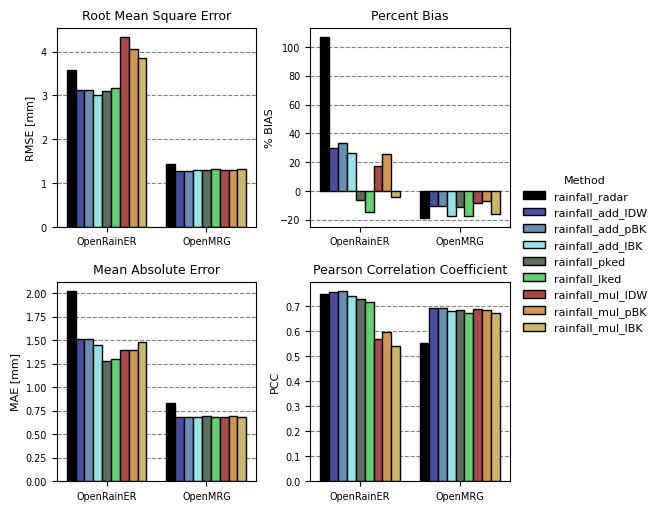

In [31]:
# Load data
data_ER = pd.read_csv('metrics_OpenRainER.csv')
data_GT = pd.read_csv('metrics_OpenMRG.csv')
data = pd.concat([data_ER, data_GT], ignore_index=True)

# Metrics & titles
metrics = [
    'root_mean_square_error',
    'percent_bias',
    'mean_absolute_error',
    'pearson_correlation_coefficient'
]
titles = [
    'Root Mean Square Error',
    'Percent Bias',
    'Mean Absolute Error',
    'Pearson Correlation Coefficient'
]

axis_names = [
    'RMSE [mm]',
    '% BIAS',
    'MAE [mm]',
    'PCC'
]

# Filter methods
methods_to_plot = [
    'rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
    'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
    'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK'
]
filtered_data = data[data['method'].isin(methods_to_plot)]

# Custom palette
palette = {
    'rainfall_radar': "#000000",
    'rainfall_add_IDW': "#3b41ab",
    'rainfall_add_pBK': "#5e8ebc",
    'rainfall_add_lBK': "#86eff3",
    'rainfall_pked': "#57735a",
    'rainfall_lked': "#53e261",
    'rainfall_mul_IDW': "#b73a3a",
    'rainfall_mul_pBK': "#e3993f",
    'rainfall_mul_lBK': "#dbc15a",
}

# Create figure with constrained_layout (no tight_layout warning)
fig = plt.figure(figsize=(6.5, 5), constrained_layout=True)
gs = fig.add_gridspec(
    2, 3, width_ratios=[1, 1, 0.5]  # two plot columns + narrow legend column
)

# Axes in first two columns
axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1])
]

# Plot each metric
for ax, metric, title, ax_name in zip(axes, metrics, titles, axis_names):
    sns.barplot(
        data=filtered_data,
        x='dataset', y=metric, hue='method',
        ax=ax, palette=palette, edgecolor='black'
    )
    ax.set_title(title, fontsize=9)
    ax.set_xlabel('', fontsize=8)
    ax.set_ylabel(ax_name, fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.get_legend().remove()
    ax.grid(linestyle='--', color='gray', axis='y')
    ax.set_axisbelow(True)

# Single legend in the narrow third column
handles, labels = axes[0].get_legend_handles_labels()
legend_ax = fig.add_subplot(gs[:, 2])  # spanning both rows
legend_ax.axis('off')  # hide axis
legend_ax.legend(
    handles, labels, title='Method', fontsize=8, title_fontsize=8,
    loc='center', frameon=False
)

fig.savefig('metrics_plot.png', dpi=300, bbox_inches='tight')
plt.show

# RANGE CHECK ANALYSIS

<function matplotlib.pyplot.show(close=None, block=None)>

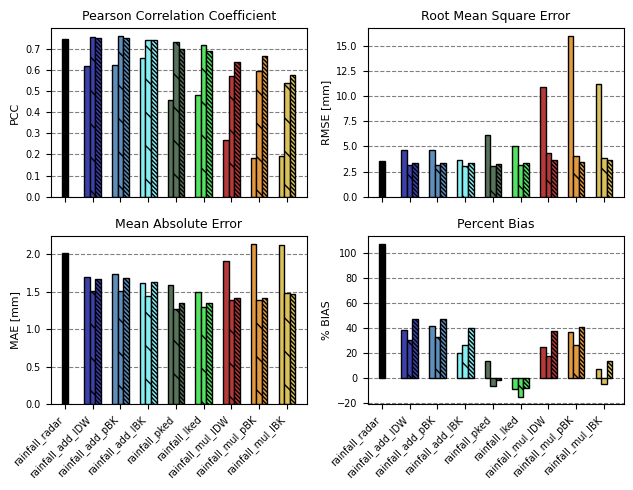

In [32]:
# Load data unchecked
data_ER_uc = pd.read_csv('metrics_OpenRainER_uc.csv')
data_ER_uc['status'] = np.full(len(data_ER_uc), 'no check')

# Load data baseline
data_ER = pd.read_csv('metrics_OpenRainER.csv')
data_ER['status'] = np.full(len(data_ER), 'baseline')

# Load data conservative check
data_ER_cc = pd.read_csv('metrics_OpenRainER_cc.csv')
data_ER_cc['status'] = np.full(len(data_ER_cc), 'conservative check')

data = pd.concat([data_ER_uc, data_ER, data_ER_cc])
data.reset_index(inplace=True)

data = data.drop(data[(data["method"] == "rainfall_radar") & (data["status"] == "conservative check")].index)
data = data.drop(data[(data["method"] == "rainfall_radar") & (data["status"] == "no check")].index)

metrics = ['pearson_correlation_coefficient', 'root_mean_square_error', 
           'mean_absolute_error', 'percent_bias']
titles = ['Pearson Correlation Coefficient', 'Root Mean Square Error', 
          'Mean Absolute Error', 'Percent Bias']
axis_names = ['PCC', 'RMSE [mm]','MAE [mm]','% BIAS']
statuses = ['no check', 'baseline', 'conservative check']

methods_to_plot = [
    'rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
    'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
    'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK'
]

filtered_data = data[data['method'].isin(methods_to_plot)]

palette = {
    'rainfall_radar': "#000000",
    'rainfall_add_IDW': "#3b41ab",
    'rainfall_add_pBK': "#5e8ebc",
    'rainfall_add_lBK': "#86eff3",
    'rainfall_pked': "#57735a",
    'rainfall_lked': "#53e261",
    'rainfall_mul_IDW': "#b73a3a",
    'rainfall_mul_pBK': "#e3993f",
    'rainfall_mul_lBK': "#dbc15a",
}

# Define hatches for statuses
hatch_map = {
    'no check': '',
    'baseline': '\\', 
    'conservative check': '\\\\\\\\\\\\\\\\'
}

fig, axes = plt.subplots(2, 2, figsize=(6.5, 5), sharex=True)
axes = axes.flatten()
width = 0.2
x = np.arange(len(methods_to_plot))

for ax, metric, title, ax_name in zip(axes, metrics, titles, axis_names):
    for j, status in enumerate(statuses):
        values = []
        for method in methods_to_plot:
            df_status = filtered_data[filtered_data['status'] == status]
            if method == 'rainfall_radar' and status != 'baseline':
                values.append(np.nan)
            else:
                val = df_status[df_status['method'] == method][metric]
                values.append(val.values[0] if len(val) > 0 else np.nan)
        bars = ax.bar(x + j*width, values, width=width, edgecolor='black',
                      color=[palette.get(method) for method in methods_to_plot])
        # Apply hatches
        for bar in bars:
            bar.set_hatch(hatch_map[status])

    ax.set_title(title, fontsize=9)
    ax.set_xticks(x + width)
    ax.set_xticklabels(methods_to_plot, rotation=45, ha='right', fontsize=7)
    ax.set_ylabel(ax_name, fontsize=8)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(linestyle='--', color='gray', axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()
fig.savefig('rangecheck_analysis.png', dpi=300, bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

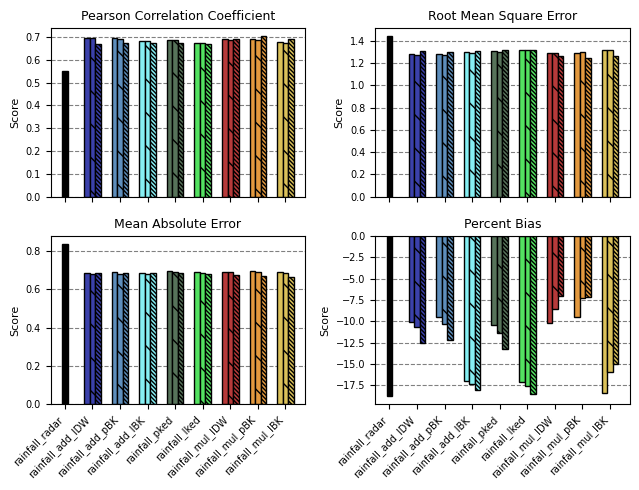

In [26]:
# Load data unchecked
data_GT_uc = pd.read_csv('metrics_OpenMRG_uc.csv')
data_GT_uc['status'] = np.full(len(data_GT_uc), 'no check')

# Load data baseline
data_GT = pd.read_csv('metrics_OpenMRG.csv')
data_GT['status'] = np.full(len(data_GT), 'baseline')

# Load data conservative check
data_GT_cc = pd.read_csv('metrics_OpenMRG_cc.csv')
data_GT_cc['status'] = np.full(len(data_GT_cc), 'conservative check')

data = pd.concat([data_GT_uc, data_GT, data_GT_cc])
data.reset_index(inplace=True)

data = data.drop(data[(data["method"] == "rainfall_radar") & (data["status"] == "conservative check")].index)
data = data.drop(data[(data["method"] == "rainfall_radar") & (data["status"] == "no check")].index)

metrics = ['pearson_correlation_coefficient', 'root_mean_square_error', 
           'mean_absolute_error', 'percent_bias']
titles = ['Pearson Correlation Coefficient', 'Root Mean Square Error', 
          'Mean Absolute Error', 'Percent Bias']
statuses = ['no check', 'baseline', 'conservative check']

methods_to_plot = [
    'rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
    'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
    'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK'
]

filtered_data = data[data['method'].isin(methods_to_plot)]

palette = {
    'rainfall_radar': "#000000",
    'rainfall_add_IDW': "#3b41ab",
    'rainfall_add_pBK': "#5e8ebc",
    'rainfall_add_lBK': "#86eff3",
    'rainfall_pked': "#57735a",
    'rainfall_lked': "#53e261",
    'rainfall_mul_IDW': "#b73a3a",
    'rainfall_mul_pBK': "#e3993f",
    'rainfall_mul_lBK': "#dbc15a",
}

# Define hatches for statuses
hatch_map = {
    'no check': '',
    'baseline': '\\', 
    'conservative check': '\\\\\\\\\\\\\\\\'
}

fig, axes = plt.subplots(2, 2, figsize=(6.5, 5), sharex=True)
axes = axes.flatten()
width = 0.2
x = np.arange(len(methods_to_plot))

for ax, metric, title in zip(axes, metrics, titles):
    for j, status in enumerate(statuses):
        values = []
        for method in methods_to_plot:
            df_status = filtered_data[filtered_data['status'] == status]
            if method == 'rainfall_radar' and status != 'baseline':
                values.append(np.nan)
            else:
                val = df_status[df_status['method'] == method][metric]
                values.append(val.values[0] if len(val) > 0 else np.nan)
        bars = ax.bar(x + j*width, values, width=width, edgecolor='black',
                      color=[palette.get(method) for method in methods_to_plot])
        # Apply hatches
        for bar in bars:
            bar.set_hatch(hatch_map[status])

    ax.set_title(title, fontsize=9)
    ax.set_xticks(x + width)
    ax.set_xticklabels(methods_to_plot, rotation=45, ha='right', fontsize=7)
    ax.set_ylabel('Score', fontsize=8)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(linestyle='--', color='gray', axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()
fig.savefig('rangecheck_analysis_MRG.png', dpi=300, bbox_inches='tight')
plt.show

# DISTANCE ANALYSIS

In [21]:
dataset = 'OpenRainER'
adj_path = 'data/adjusted_fields/'

ds_gauges = xr.open_dataset('data/covi_2024_OpenRainER/AWS_rainfall.nc')        
ds_rad = xr.open_dataset("data/covi_2024_OpenRainER/openrainer_radar.nc")       
ds_cmls = xr.open_dataset("data/processed_cml_OpenRainER.nc").R_acc             

# adding adjusted field and naming
ds_rad = ds_rad.rename({'rainfall_amount':'rainfall_radar'})  
ds_rad['rainfall_add_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_add_IDW.nc').rainfall_add_IDW
ds_rad['rainfall_add_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_pBK.nc').rainfall_add_pBK
ds_rad['rainfall_add_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_add_lBK.nc').rainfall_add_lBK
ds_rad['rainfall_mul_IDW']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_IDW.nc').rainfall_mul_IDW
ds_rad['rainfall_mul_pBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_pBK.nc').rainfall_mul_pBK
ds_rad['rainfall_mul_lBK']=xr.open_dataset(adj_path+dataset+'_rainfall_mul_lBK.nc').rainfall_mul_lBK
ds_rad['rainfall_pked']=xr.open_dataset(adj_path+dataset+'_rainfall_pked.nc').rainfall_ked
ds_rad['rainfall_lked']=xr.open_dataset(adj_path+dataset+'_rainfall_lked.nc').rainfall_ked

In [22]:
# fields = [[gauge name, radar name]]
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best" 
)

for field in fields:
    ds_gauges[field] = get_grid_at_points(
        da_gridded_data=ds_rad[field],
        da_point_data=ds_gauges.rainfall_amount,  
    )

In [23]:
distances = np.arange(2000, 32000, 2000) # [m]
n_gauges = np.array([])
threshold = 0.2

fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

start = 0
for max_distance in distances:
    closest_neigbors = plg.spatial.get_closest_points_to_line(
        ds_cmls, ds_gauges.rainfall_amount, max_distance=max_distance, n_closest=len(ds_gauges.id.values)
    )

    closest_rgs = closest_neigbors.neighbor_id.values.flatten()
    ds_closegauges = ds_gauges.sel(id=np.unique(closest_rgs[closest_rgs!= None]))
    n_gauges = np.concat([n_gauges, np.array([len(ds_closegauges.id.values)])])

    for field in fields:

        metric = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
            reference=ds_closegauges.rainfall_amount.values.flatten(),
            estimate=ds_closegauges[field].values.flatten(),
            ref_thresh=threshold,
            est_thresh=threshold,
        )])
        metric['distance'] = [max_distance]
        metric['field'] = [field]

        if start == 0:
            result_metric = metric
            start += 1
        else:
            result_metric = pd.concat([result_metric, metric])

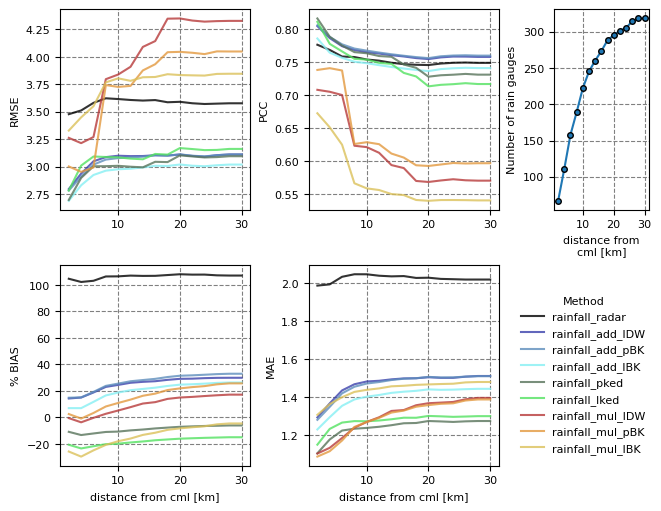

In [24]:
fields = ['rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
          'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
          'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK']

colors = ["#000000", "#3b41ab","#5e8ebc", 
          "#86eff3","#57735a", "#53e261",
          "#b73a3a",  "#e3993f", "#dbc15a"]

# Create figure with constrained_layout
fig = plt.figure(figsize=(6.5, 5), constrained_layout=True)
gs = gridspec.GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.5])

# Subplots
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax02 = fig.add_subplot(gs[0, 2])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])

handles = []

# --- RMSE ---
for field, color in zip(fields, colors):
    result = result_metric[result_metric.field == field]
    line, = ax00.plot(result.distance/1000, result.root_mean_square_error,
                      label=field, alpha=0.8, markersize=4, color=color)
    handles.append(line)

ax00.set_ylabel('RMSE', fontsize=8)
ax00.tick_params(axis='both', labelsize=8)
ax00.grid(linestyle='--', color='gray')

# --- PCC ---
for field, color in zip(fields, colors):
    result = result_metric[result_metric.field == field]
    ax01.plot(result.distance/1000, result.pearson_correlation_coefficient,
              alpha=0.8, markersize=4, color=color)

ax01.set_ylabel('PCC', fontsize=8)
ax01.tick_params(axis='both', labelsize=8)
ax01.grid(linestyle='--', color='gray')

# --- Number of rain gauges ---
ax02.plot(distances/1000, n_gauges, marker='o', markersize=4, markeredgecolor='black')
ax02.set_xlabel('distance from\ncml [km]', fontsize=8)
ax02.set_ylabel('Number of rain gauges', fontsize=8)
ax02.tick_params(axis='both', labelsize=8)
ax02.grid(linestyle='--', color='gray')

# --- %BIAS ---
for field, color in zip(fields, colors):
    result = result_metric[result_metric.field == field]
    ax10.plot(result.distance/1000, result.percent_bias,
              alpha=0.8, markersize=4, color=color)

ax10.set_xlabel('distance from cml [km]', fontsize=8)
ax10.set_ylabel('% BIAS', fontsize=8)
ax10.tick_params(axis='both', labelsize=8)
ax10.grid(linestyle='--', color='gray')

# --- MAE ---
for field, color in zip(fields, colors):
    result = result_metric[result_metric.field == field]
    ax11.plot(result.distance/1000, result.mean_absolute_error,
              alpha=0.8, markersize=4, color=color)

ax11.set_xlabel('distance from cml [km]', fontsize=8)
ax11.set_ylabel('MAE', fontsize=8)
ax11.tick_params(axis='both', labelsize=8)
ax11.grid(linestyle='--', color='gray')

# --- Legend placed relative to the figure ---
fig.legend(handles, fields, title='Method',
           fontsize=8, title_fontsize=8,
           loc='center right', bbox_to_anchor=(1, 0.26),
           frameon=False, ncol=1)

# Save figure
plt.savefig('distance_analysis.png', dpi=600, bbox_inches='tight')
plt.show()

# INTENSITY ANALYSIS

<function matplotlib.pyplot.show(close=None, block=None)>

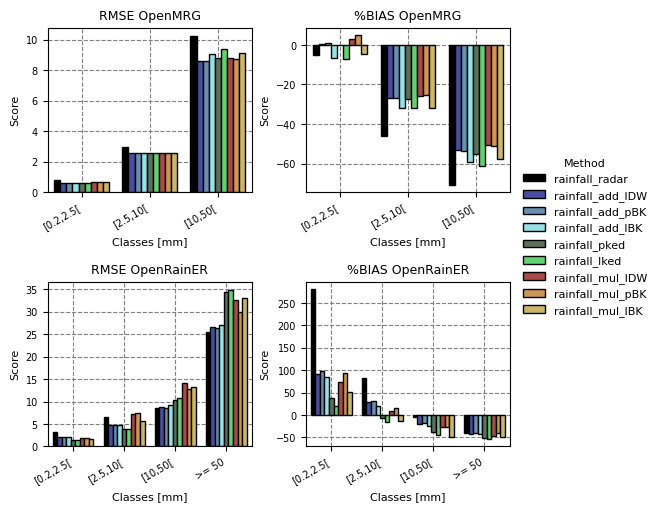

In [25]:
# Load data
data_ER = pd.read_csv('intensity_analysis_OpenRainER.csv')
data_GT = pd.read_csv('intensity_analysis_OpenMRG.csv')

# Filter methods
methods_to_plot = [
    'rainfall_radar', 'rainfall_add_IDW', 'rainfall_add_pBK', 
    'rainfall_add_lBK', 'rainfall_pked', 'rainfall_lked',
    'rainfall_mul_IDW', 'rainfall_mul_pBK', 'rainfall_mul_lBK'
]
data_ER = data_ER[data_ER['field'].isin(methods_to_plot)]
data_GT = data_GT[data_GT['field'].isin(methods_to_plot)]

# Custom palette
palette = {
    'rainfall_radar': "#000000",
    'rainfall_add_IDW': "#3b41ab",
    'rainfall_add_pBK': "#5e8ebc",
    'rainfall_add_lBK': "#86eff3",
    'rainfall_pked': "#57735a",
    'rainfall_lked': "#53e261",
    'rainfall_mul_IDW': "#b73a3a",
    'rainfall_mul_pBK': "#e3993f",
    'rainfall_mul_lBK': "#dbc15a",
}


fig = plt.figure(figsize=(6.5, 5), constrained_layout=True)
gs = fig.add_gridspec(
    2, 3, width_ratios=[1, 1, 0.5]  # two plot columns + narrow legend column
)

axes = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[0, 1]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[1, 1])
]

sns.barplot(
    data=data_GT,
    x='class', y='root_mean_square_error', hue='field',
    ax=axes[0], palette=palette, edgecolor='black'
)
axes[0].set_title('RMSE OpenMRG', fontsize=9)
axes[0].set_xlabel('Classes [mm]', fontsize=8)
axes[0].set_ylabel('Score', fontsize=8)
axes[0].tick_params(axis='both', which='major', labelsize=7)
axes[0].get_legend().remove()
axes[0].grid(linestyle='--', color='gray')

sns.barplot(
    data=data_GT,
    x='class', y='percent_bias', hue='field',
    ax=axes[1], palette=palette, edgecolor='black'
)
axes[1].set_title('%BIAS OpenMRG', fontsize=9)
axes[1].set_xlabel('Classes [mm]', fontsize=8)
axes[1].set_ylabel('Score', fontsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=7)
axes[1].get_legend().remove()
axes[1].grid(linestyle='--', color='gray')

sns.barplot(
    data=data_ER,
    x='class', y='root_mean_square_error', hue='field',
    ax=axes[2], palette=palette, edgecolor='black'
)
axes[2].set_title('RMSE OpenRainER', fontsize=9)
axes[2].set_xlabel('Classes [mm]', fontsize=8)
axes[2].set_ylabel('Score', fontsize=8)
axes[2].tick_params(axis='both', which='major', labelsize=7)
axes[2].get_legend().remove()
axes[2].grid(linestyle='--', color='gray')

sns.barplot(
    data=data_ER,
    x='class', y='percent_bias', hue='field',
    ax=axes[3], palette=palette, edgecolor='black'
)
axes[3].set_title('%BIAS OpenRainER', fontsize=9)
axes[3].set_xlabel('Classes [mm]', fontsize=8)
axes[3].set_ylabel('Score', fontsize=8)
axes[3].tick_params(axis='both', which='major', labelsize=7)
axes[3].get_legend().remove()
axes[3].grid(linestyle='--', color='gray')

# Single legend in the narrow third column
handles, labels = axes[0].get_legend_handles_labels()
legend_ax = fig.add_subplot(gs[:, 2])  # spanning both rows
legend_ax.axis('off')  # hide axis
legend_ax.legend(
    handles, labels, title='Method', fontsize=8, title_fontsize=8,
    loc='center', frameon=False
)

for ax in axes:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    ax.set_axisbelow(True)

fig.savefig('intensity_analysis.png', dpi=300, bbox_inches='tight')
plt.show